#  Dimensionality Reduction
*This is a notebook about Dimensionality Reduction*

## SETUP

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter8_dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [24]:
# Extra modules imported during the work
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

## PCA

In [3]:
# Build a simple 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### Preserving the Variance


### Principal Components

In [5]:
# Find the principal components using Singular Value Decomposition (SVD)
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] # 1st principal component
c2 = Vt.T[:, 1] # 2nd principal component

**Remark:** PCA assumes that the dataset is centered around the origin, which means the data should be centered before PCA implementation (sklearn will take care of it automatically).

In [6]:
# 1st principal component
c1

array([0.93636116, 0.29854881, 0.18465208])

In [7]:
# 2nd principal component
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

### Projecting Down to d Dimensions

In [11]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2) # X in 2D plane using SVD
X2D_custom = X2D

### Using Scikit-Learn

In [12]:
# Implement PCA using SVD on the 3D dataset (sklearn)
pca = PCA(n_components=2)
X2D = pca.fit_transform(X) # automatically takes care of centering data
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [14]:
# Compare with the customized one
X2D_custom[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

**Remark:** Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be *flipped*. In this example, **PCA using Scikit-Learn gives the same projection as the one given by the SVD approach**, except both axes are flipped.

In [16]:
# Compare the results
np.allclose(X2D, -X2D_custom)

True

In [18]:
# Recover the 3D points projected on the plane from PCA 2D subspace 
X3D_inv = pca.inverse_transform(X2D)
X3D_inv[:5]

array([[-1.01450604, -0.54656333, -0.27441525],
       [-0.02103231,  0.55108376,  0.18101894],
       [-0.95379477, -0.4668077 , -0.24237013],
       [-0.91717404,  0.22083765, -0.01049779],
       [-0.74607229,  0.22027492,  0.00492637]])

In [19]:
# Compare the inverse transform to the origin
np.allclose(X3D_inv, X)

False

**Evaluate:** Some loss of information during the projection step is observed.

In [20]:
# Compute the reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [21]:
# Access to the principal components computed 
pca.components_ 

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

**Remark:** PCs are expressed as horizontal vectors.

### Explained Variance Ratio

In [22]:
# Inspect the explained variance ratios of the 3D dataset
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

**Evaluate:** 
- 84.2% of the dataset’s variance lies along the first axis
- 14.6% lies along the second axis
- 1.1% for the third axis (Resonable to assume that this axis probably carries little information

In [23]:
# Compute the loss of variance by projecting down to 2D
1 - pca.explained_variance_ratio_.sum() # 1.1%

0.011195535570688975

### Choosing the Right Number of Dimensions

In [25]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [26]:
# Split MNIST dataset
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
# Compute the minimum number of dimensions required to preserve 95% of the training set’s variance
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [28]:
# Compute the minimum number of dimensions (but easier)
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [29]:
# Check the sum of the explained variance ratio
np.sum(pca.explained_variance_ratio_)

0.9503684424557428

Saving figure explained_variance_plot


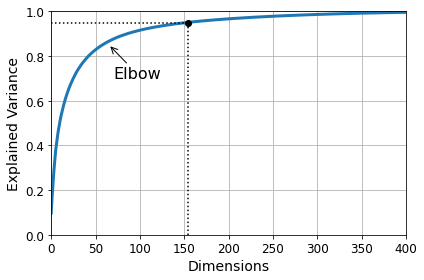

In [30]:
# Plot explained variance ratio as a function of the number of dimensions
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()